In [1]:
from CustomPongEnv_v0_ram import Custom_Pong
import numpy as np
import random

from math_helper_functions import pong_state_to_obs, normalise_A, normalise_B,softmax

import pymdp
from pymdp import utils

from scipy.stats import entropy

random.seed(10)
np.random.seed(10)

env = Custom_Pong()
states = env.observation_space.shape[0]
actions = env.action_space.n

C:\Users\aswin\anaconda3\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\aswin\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [2]:
states, actions

(6, 3)

<img src="pong.png" width="600" align="left">

<img src="ExpResults.png" width="300" align="left">

# Generative model

In [3]:
# (Hidden)Factors
# Ball position (x) (Hypothesis)
s1_size = 5
# Ball position (y) (Hypothesis)
s2_size = 5
# Ball velocity vx 
s3_size = 2
#Ball velocity vy
s4_size = 2

# Paddle position (Hypothesis)
s5_size = 5
# Paddle vel
s6_size = 2

#score
s7_size = 3

num_states = [s1_size, s2_size, s3_size, s4_size, s5_size, s6_size, s7_size]
num_factors = len(num_states)

# Rewards
reward_modes = 3 #Max score-5 (assumption)

# Controls
s1_actions = ['Do nothing']
s2_actions = ['Do nothing']
s3_actions = ['Stay', 'Play-Up', 'Play-Down']
s4_actions = ['Do nothing']
s5_actions = ['Do nothing']
s6_actions = ['Do nothing']
s7_actions = ['Do nothing']

num_controls = [len(s1_actions), len(s2_actions), len(s3_actions), len(s4_actions), len(s5_actions), len(s6_actions), len(s7_actions)]

# Observations
#Ball-x
o1_obs_size = s1_size
#Ball-y
o2_obs_size = s2_size

#Ball-vx
o3_obs_size = s3_size
#Ball-vy
o4_obs_size = s4_size

#Paddle-pos
o5_obs_size = s5_size
#Paddle-velocity
o6_obs_size = s6_size

#Reward (Shock, Chocolate, and Nothing)
reward_obs_size = reward_modes

num_obs = [o1_obs_size, o2_obs_size, o3_obs_size, o4_obs_size, o5_obs_size, o6_obs_size, reward_obs_size]
num_modalities = len(num_obs)

EPS_VAL = 1e-16 # Negligibleconstant

# Likelhiood Dynamics
A = utils.random_A_matrix(num_obs, num_states)*0 + EPS_VAL

In [4]:
# All observations are initialised as fully-observable
for i in range(num_states[1]):
    for j in range(num_states[2]):
        for k in range(num_states[3]):
            for l in range(num_states[4]):
                for m in range(num_states[5]):
                    for n in range(num_states[6]):
                        A[0][:,:,i,j,k,l,m,n] = np.eye(num_states[0]) + EPS_VAL

for i in range(num_states[0]):
    for j in range(num_states[2]):
        for k in range(num_states[3]):
            for l in range(num_states[4]):
                for m in range(num_states[5]):
                    for n in range(num_states[6]):
                        A[1][:,i,:,j,k,l,m,n] = np.eye(num_states[1]) + EPS_VAL

for i in range(num_states[0]):
    for j in range(num_states[1]):
        for k in range(num_states[3]):
            for l in range(num_states[4]):
                for m in range(num_states[5]):
                    for n in range(num_states[6]):
                        A[2][:,i,j,:,k,l,m,n] = np.eye(num_states[2]) + EPS_VAL
                        
for i in range(num_states[0]):
    for j in range(num_states[1]):
        for k in range(num_states[2]):
            for l in range(num_states[4]):
                for m in range(num_states[5]):
                    for n in range(num_states[6]):
                        A[3][:,i,j,k,:,l,m,n] = np.eye(num_states[3]) + EPS_VAL
                        
for i in range(num_states[0]):
    for j in range(num_states[1]):
        for k in range(num_states[2]):
            for l in range(num_states[3]):
                for m in range(num_states[5]):
                    for n in range(num_states[6]):
                        A[4][:,i,j,k,l,:,m,n] = np.eye(num_states[4]) + EPS_VAL
                        
for i in range(num_states[0]):
    for j in range(num_states[1]):
        for k in range(num_states[2]):
            for l in range(num_states[3]):
                for m in range(num_states[4]):
                    for n in range(num_states[6]):
                        A[5][:,i,j,k,l,m,:,n] = np.eye(num_states[5]) + EPS_VAL
                        
for i in range(num_states[0]):
    for j in range(num_states[1]):
        for k in range(num_states[2]):
            for l in range(num_states[3]):
                for m in range(num_states[4]):
                    for n in range(num_states[5]):
                        A[6][:,i,j,k,l,m,n,:] = np.eye(num_states[6]) + EPS_VAL

In [5]:
# Transisition dynamics
# Initialised as random becuase the agent need to learn the dynamics

B = utils.random_B_matrix(num_states, num_controls)*0 + EPS_VAL

numS = 1
for i in num_states:
    numS *= i
numA = 1
for i in num_controls:
    numA *= i

A = normalise_A(A, num_states, num_modalities)
B = normalise_B(B, num_states, num_controls)

D = utils.obj_array_uniform(num_states)

A_naive = A
B_naive = B

In [6]:
numS, numA

(3000, 3)

## State to decision mapping

In [7]:
C = utils.obj_array_zeros([1])
C[0] = np.random.rand(numA, numS)*0 + EPS_VAL
C = normalise_A(C, num_states, num_modalities=1)

#High risk mapping
C_p = utils.obj_array_zeros([1])

one = np.ones((numA, numS))
C_p[0] = np.divide(one, C[0])

C_p = normalise_A(C_p, num_states, num_modalities=1)

In [8]:
# Testing

print("Policy mapping:", C[0][:,0])
print("Anti policy mapping:", C_p[0][:,0])

Policy mapping: [0.33333333 0.33333333 0.33333333]
Anti policy mapping: [0.33333333 0.33333333 0.33333333]


In [9]:
num_factors

7

In [10]:
A.shape, A[0].shape

((7,), (5, 5, 5, 2, 2, 5, 2, 3))

In [11]:
%%time 

trials = 1
episodes = 400

#Factor for resolution of obeservations
factor = 50

rally_length_raw = np.zeros((trials,episodes))
e = []

horizon = 10000
T = horizon

for trial in range(trials):
    print("trial", trial)
    
    EPS_VAL = 1e-16 #negligibleconstant
    # Likelhiood Dynamics
    A = A_naive

    # Transisition dynamics
    # Initialised as random becuase the agent need to learn the dynamics
    B = B_naive

    # Normalising A and B as probability distributions

    A = normalise_A(A, num_states, num_modalities)
    B = normalise_B(B, num_states, num_controls)

    # Prior preferences for biasing the generative model to control behaviour is unchanging
    
    #Prior over hidden-states before a fresh trial
    D = utils.obj_array_uniform(num_states)
    
    Gamma = np.zeros((horizon, 2))
    for i in range(horizon):
        Gamma[i,0] = 0.5
        Gamma[i,1] = 0.5
    
    #Episodes inside a trial
    for episode in range(episodes):
        print("episode", episode)

        state = env.reset()
        done = False
        score = 0

        t=0
        qs = D
        qs_prev = qs
        q_states_vec = 1
        for fac in range(num_factors):
            q_states_vec = np.kron(q_states_vec, qs[fac])
        qs_prev = q_states_vec
        
        while not done:
            q_states_vec = 1
            for fac in range(num_factors):
                q_states_vec = np.kron(q_states_vec, qs[fac])
            
            c_s = np.matmul(np.log(C[0]), q_states_vec)
            p_d = softmax(c_s)

            action = np.random.choice([0,1,2], size=None, replace=True, p=p_d)
   
            state, reward, done, info = env.step(action)
            score += reward

            observation = pong_state_to_obs(state, reward, factor)

            qs = pymdp.inference.update_posterior_states(A, observation, prior = None)
            
            if(t == 0):
                qs0 = qs

            # Learning
            # A = pymdp.learning.update_obs_likelihood_dirichlet(A, A, observation, qs, lr=1.0, modalities='all')

            # actions = np.array([int(action),0])
            # B = pymdp.learning.update_state_likelihood_dirichlet(B, B, actions, qs, qs_prev_raw, lr=1.0, factors='all')
            
            #Reward 0, 1, or -1
            if(reward != 0):
                for ii in range(t):
                    if((Gamma[ii][0] + reward/(t-ii) < 0.999) and (Gamma[ii][0] - reward/(t-ii) > 0.001)):
                        Gamma[ii][0] += reward/(t-ii)
                        Gamma[ii][1] = 1 - Gamma[ii][0]

            # Learning C
            des = utils.onehot(action,numA)
            a = np.reshape(des, (des.shape[0],1))
            
            b = np.reshape(qs_prev, (1,qs_prev.shape[0]))
            c_up = np.kron(a,b)
            
            C[0] += (1 - 2*Gamma[t][1])*c_up
            C[0] = np.clip(C[0], EPS_VAL, None)
            C = normalise_A(C, num_states, 1)

            e.append([np.sum(entropy(A[0])), np.sum(entropy(A[1])), np.sum(entropy(A[2])), np.sum(entropy(A[3])), np.sum(entropy(A[4])), np.sum(entropy(A[5])), np.sum(entropy(A[6])), np.sum(entropy(B[0])) , np.sum(entropy(B[1]))])
            
            #if(t == 0):
                # D = pymdp.learning.update_state_prior_dirichlet(D, qs0, lr=1.0, factors='all')
                # for i in range(num_factors):
                    # D[i] = pymdp.maths.softmax(D[i])

            t += 1
            
            qs_prev = q_states_vec
            qs_prev_raw = qs
            
            # if(t == T-1):
                # t = 0
                # Normalising A and B
                # A = normalise_A(A, num_states, num_modalities)
                # B = normalise_B(B, num_states, num_controls)

        rally_length_raw[trial][episode] = score+1

    env.close()

trial 0
episode 0
episode 1
episode 2
episode 3
episode 4
episode 5
episode 6
episode 7
episode 8
episode 9
episode 10
episode 11
episode 12
episode 13
episode 14
episode 15
episode 16
episode 17
episode 18
episode 19
episode 20
episode 21
episode 22
episode 23
episode 24
episode 25
episode 26
episode 27
episode 28
episode 29
episode 30
episode 31
episode 32
episode 33
episode 34
episode 35
episode 36
episode 37
episode 38
episode 39
episode 40
episode 41
episode 42
episode 43
episode 44
episode 45
episode 46
episode 47
episode 48
episode 49
episode 50
episode 51
episode 52
episode 53
episode 54
episode 55
episode 56
episode 57
episode 58
episode 59
episode 60
episode 61
episode 62
episode 63
episode 64
episode 65
episode 66
episode 67
episode 68
episode 69
episode 70
episode 71
episode 72
episode 73
episode 74
episode 75
episode 76
episode 77
episode 78
episode 79
episode 80
episode 81
episode 82
episode 83
episode 84
episode 85
episode 86
episode 87
episode 88
episode 89
episode 90
e

In [12]:
p_d

array([0.31750832, 0.38592071, 0.29657097])

In [13]:
Gamma, reward

(array([[-0.01044677,  1.01044677],
        [-0.01274009,  1.01274009],
        [-0.01505742,  1.01505742],
        ...,
        [ 0.5       ,  0.5       ],
        [ 0.5       ,  0.5       ],
        [ 0.5       ,  0.5       ]]),
 -1)

In [14]:
qs

array([array([0.19606934, 0.19606934, 0.19606934, 0.21572263, 0.19606934]),
       array([0.19606934, 0.19606934, 0.21572263, 0.19606934, 0.19606934]),
       array([0.51050947, 0.48949053]), array([0.51050947, 0.48949053]),
       array([0.21572263, 0.19606934, 0.19606934, 0.19606934, 0.19606934]),
       array([0.48949053, 0.51050947]),
       array([0.34702393, 0.32648803, 0.32648803])], dtype=object)

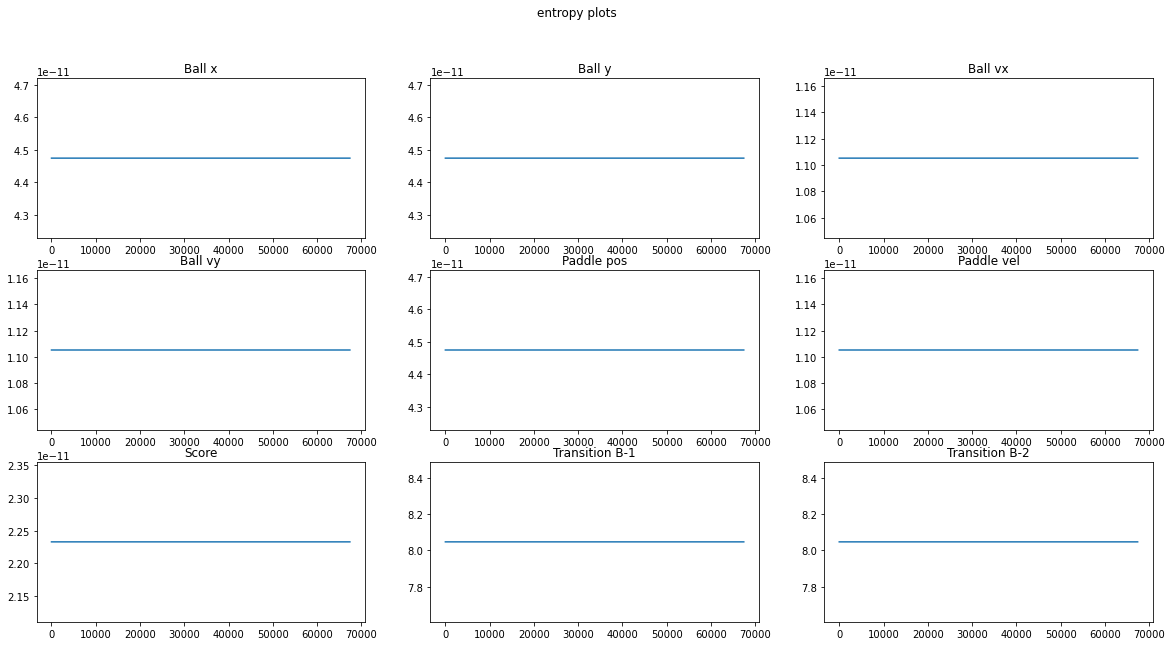

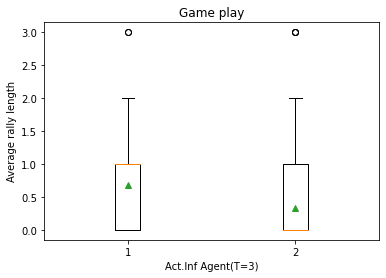

In [15]:
from matplotlib import pyplot as plt
x = np.array(e)
x.shape

fig, axs = plt.subplots(3,3,figsize=(20,10))
fig.suptitle('entropy plots')

axs[0,0].plot(x[:,0])
axs[0,0].title.set_text('Ball x')
axs[0,1].plot(x[:,1])
axs[0,1].title.set_text('Ball y')
axs[0,2].plot(x[:,2])
axs[0,2].title.set_text('Ball vx')
axs[1,0].plot(x[:,3])
axs[1,0].title.set_text('Ball vy')
axs[1,1].plot(x[:,4])
axs[1,1].title.set_text('Paddle pos')
axs[1,2].plot(x[:,5])
axs[1,2].title.set_text('Paddle vel')
axs[2,0].plot(x[:,6])
axs[2,0].title.set_text('Score')

axs[2,1].plot(x[:,7])
axs[2,1].title.set_text('Transition B-1')
axs[2,2].plot(x[:,8])
axs[2,2].title.set_text('Transition B-2')
plt.savefig('graph-6a.png', dpi=500, bbox_inches='tight')
plt.show()

rally_length_1_raw = rally_length_raw[:, 0:int(episodes/4)]
rally_length_2_raw = rally_length_raw[:, int(episodes/4):episodes]

rally_length_1 = np.mean(rally_length_1_raw, axis=0)
rally_length_2 = np.mean(rally_length_2_raw, axis=0)
x = [rally_length_1, rally_length_2]

#Plotting
xy = [x[0], x[1]]

plt.boxplot(xy, showmeans=True, positions=[1,2])
plt.ylabel("Average rally length")
plt.xlabel("Act.Inf Agent(T=3)")
plt.title("Game play")
plt.savefig('graph-6.png', dpi=500, bbox_inches='tight')

In [16]:
Gamma

array([[-0.01044677,  1.01044677],
       [-0.01274009,  1.01274009],
       [-0.01505742,  1.01505742],
       ...,
       [ 0.5       ,  0.5       ],
       [ 0.5       ,  0.5       ],
       [ 0.5       ,  0.5       ]])

In [17]:
C[0].shape

(3, 3000)

In [18]:
C_p[0].shape

(3, 3000)